# Backtesting investment strategies

## Setup

In [1]:
from ml_strategies import random_forest
from quant_strategies import minimum_variance_portfolio
import backtester
import helpers

## Data download

In [2]:
equity_symbols = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "^GSPC"]

equity_returns = helpers.download_equity_returns(equity_symbols, days=365 * 5)
stock_returns = equity_returns.drop('^GSPC', axis=1)
index_returns = equity_returns.loc[:, ['^GSPC']]
sample_split_index = len(equity_returns) // 2

## Stock returns

In [3]:
helpers.display_as_percentage(stock_returns)

,AAPL,MSFT,GOOGL,AMZN,TSLA
2018-11-12,-5.04 %,-2.46 %,-2.57 %,-4.41 %,-5.49 %
2018-11-13,-1.0 %,0.07 %,-0.13 %,-0.35 %,2.25 %
2018-11-14,-2.82 %,-1.42 %,0.63 %,-1.97 %,1.56 %
2018-11-15,2.47 %,2.2 %,1.56 %,1.28 %,1.29 %
2018-11-16,1.11 %,0.94 %,-0.26 %,-1.61 %,1.68 %
...,...,...,...,...,...
2023-11-01,1.87 %,2.35 %,1.91 %,2.94 %,2.4 %
2023-11-02,2.07 %,0.65 %,0.82 %,0.78 %,6.25 %
2023-11-03,-0.52 %,1.29 %,1.26 %,0.38 %,0.66 %
2023-11-06,1.46 %,1.06 %,0.89 %,0.82 %,-0.31 %


## Quant strategy example

In [11]:
training_data = stock_returns[:sample_split_index]
test_data = stock_returns[sample_split_index:]

quant_strategy = minimum_variance_portfolio.Strategy()
quant_strategy.train(training_data)
report = backtester.run(quant_strategy, test_data, test_data)

### Portfolio metrics

In [12]:
report.portfolio_metrics()

,Metric
Portfolio return,11.47
Portfolio volatility,31.02
Sharpe ratio,0.21


### Portfolio weights

In [13]:
helpers.display_as_percentage(report.portfolio_weights)

,AAPL,MSFT,GOOGL,AMZN,TSLA
2021-05-13,5.0 %,8.73 %,44.3 %,36.97 %,5.0 %
2021-05-14,5.0 %,8.73 %,44.3 %,36.97 %,5.0 %
2021-05-17,5.0 %,8.73 %,44.3 %,36.97 %,5.0 %
2021-05-18,5.0 %,8.73 %,44.3 %,36.97 %,5.0 %
2021-05-19,5.0 %,8.73 %,44.3 %,36.97 %,5.0 %
...,...,...,...,...,...
2023-11-01,5.0 %,8.73 %,44.3 %,36.97 %,5.0 %
2023-11-02,5.0 %,8.73 %,44.3 %,36.97 %,5.0 %
2023-11-03,5.0 %,8.73 %,44.3 %,36.97 %,5.0 %
2023-11-06,5.0 %,8.73 %,44.3 %,36.97 %,5.0 %


### Portfolio returns

#### Table

In [14]:
helpers.display_as_percentage(report.portfolio_returns)

,Minimum Variance portfolio returns
2021-05-13,-2.79 %
2021-05-14,0.77 %
2021-05-17,2.14 %
2021-05-18,0.49 %
2021-05-19,-1.06 %
...,...
2023-11-01,0.09 %
2023-11-02,2.35 %
2023-11-03,1.13 %
2023-11-06,0.82 %


#### Graph

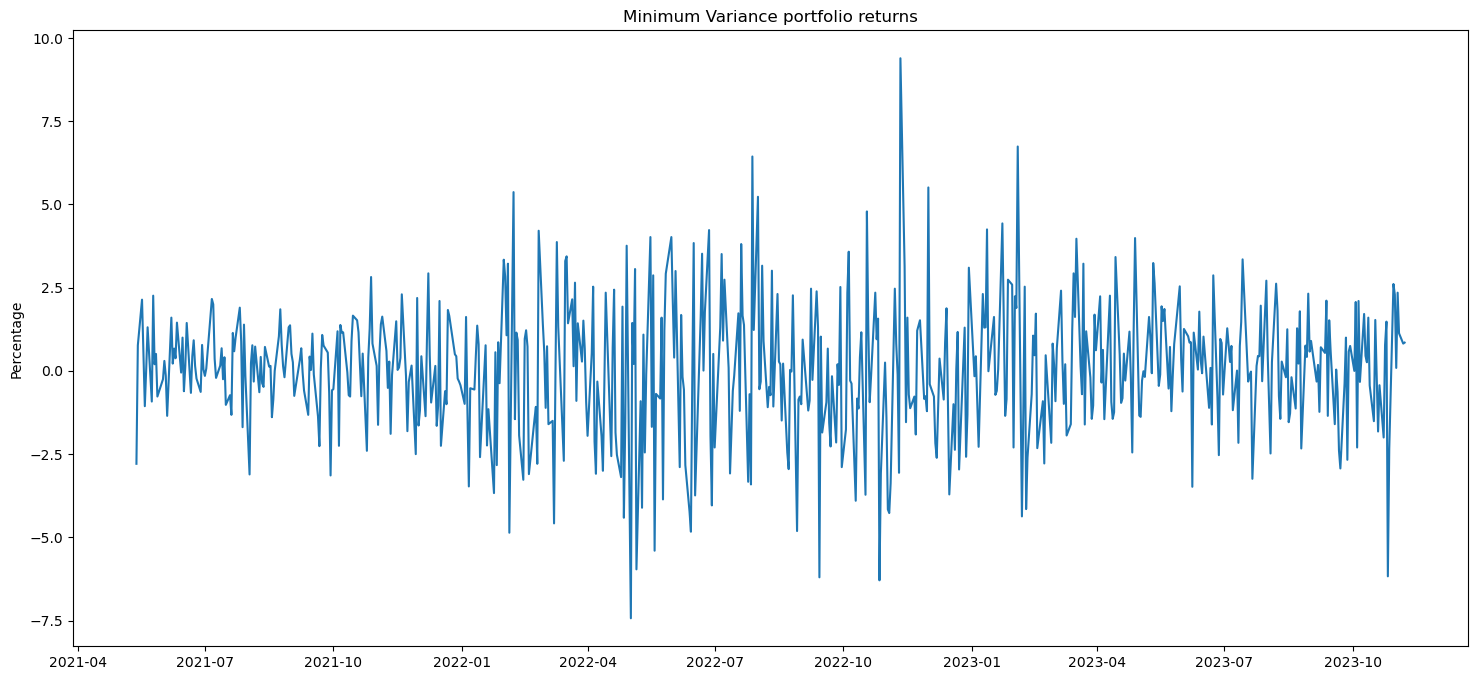

In [15]:
report.plot_portfolio_returns()

### Portfolio value

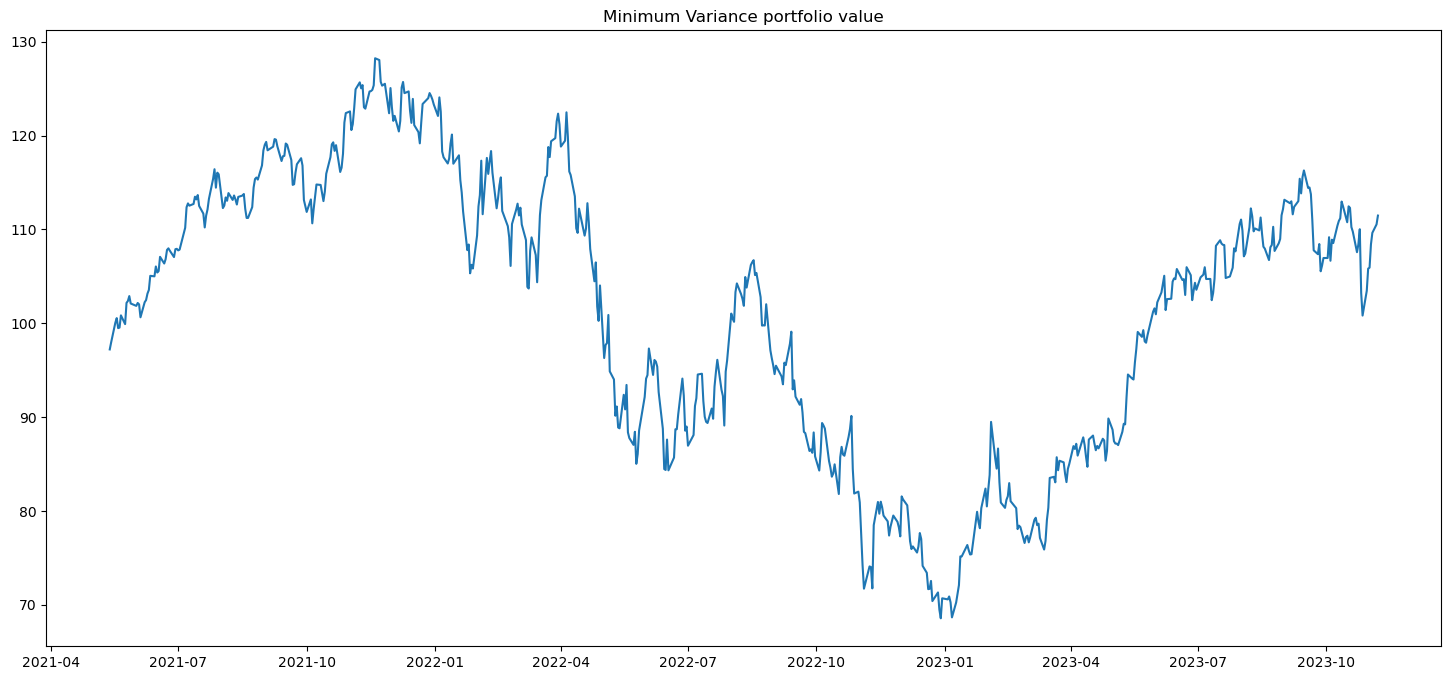

In [16]:
report.plot_portfolio_value()

### Portfolio value breakdown

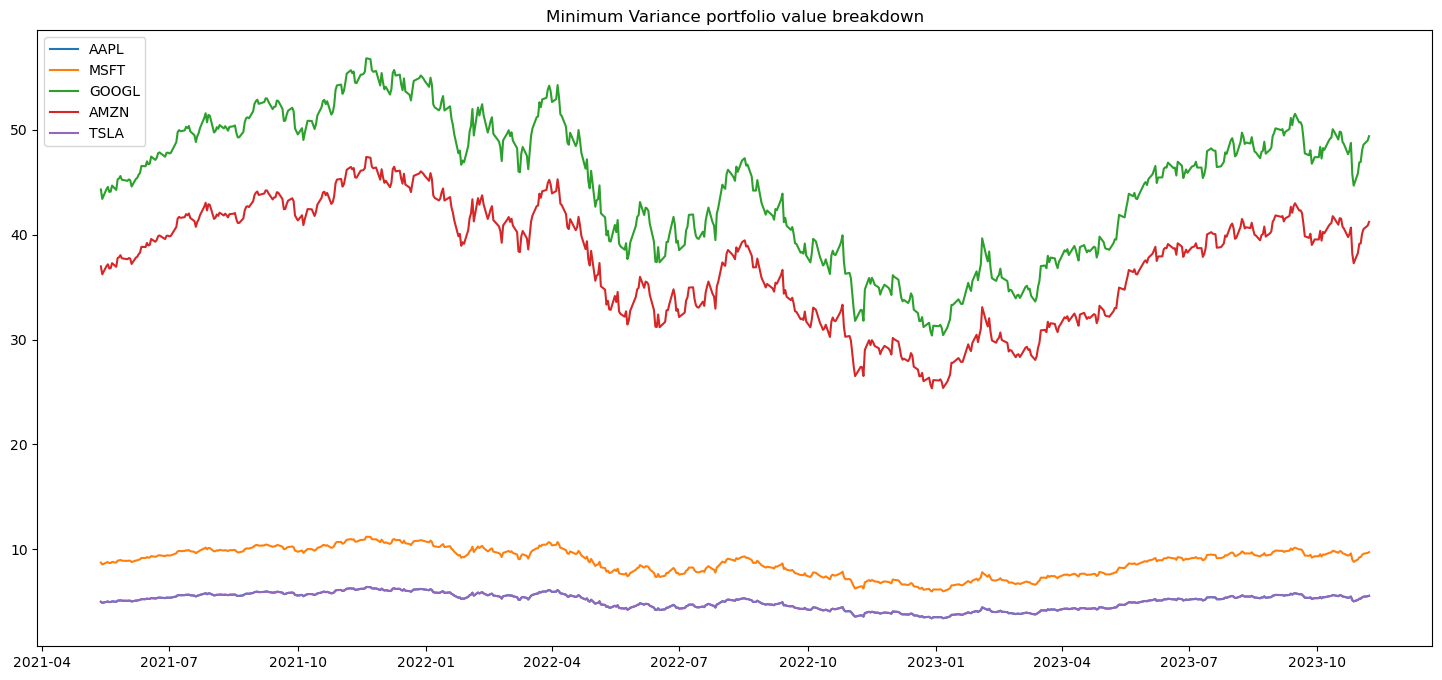

In [17]:
report.plot_portfolio_value_breakdown()

## Machine learning strategy example

In [4]:
y_training_data = stock_returns[:sample_split_index]
X_training_data = index_returns[:sample_split_index]
X_test_data = index_returns[sample_split_index:]
stock_test_data = stock_returns[sample_split_index:]

ml_strategy = random_forest.Strategy()
ml_strategy.train(y=y_training_data, X=X_training_data)
report = backtester.run(ml_strategy, X_test_data, stock_test_data)

### Portfolio metrics

In [5]:
report.portfolio_metrics()

,Metric
Portfolio return,30.49
Portfolio volatility,33.84
Sharpe ratio,0.75


### Portfolio weights

In [6]:
helpers.display_as_percentage(report.portfolio_weights)

,AAPL,MSFT,GOOGL,AMZN,TSLA
2021-05-13,16.57 %,16.57 %,16.59 %,16.57 %,33.71 %
2021-05-14,13.96 %,13.96 %,13.96 %,13.96 %,44.16 %
2021-05-17,3.19 %,3.19 %,3.19 %,3.19 %,87.23 %
2021-05-18,15.21 %,15.21 %,15.21 %,15.21 %,39.15 %
2021-05-19,15.02 %,15.02 %,15.02 %,16.42 %,38.52 %
...,...,...,...,...,...
2023-11-01,18.42 %,20.55 %,17.04 %,28.09 %,15.9 %
2023-11-02,20.6 %,22.72 %,19.89 %,18.39 %,18.39 %
2023-11-03,20.81 %,25.44 %,17.34 %,20.93 %,15.48 %
2023-11-06,14.71 %,35.43 %,14.71 %,20.43 %,14.71 %


### Portfolio returns

#### Table

In [7]:
helpers.display_as_percentage(report.portfolio_returns)

,Random Forest portfolio returns
2021-05-13,-3.27 %
2021-05-14,-0.65 %
2021-05-17,3.02 %
2021-05-18,-0.89 %
2021-05-19,-0.59 %
...,...
2023-11-01,0.41 %
2023-11-02,2.28 %
2023-11-03,1.87 %
2023-11-06,0.74 %


#### Graph

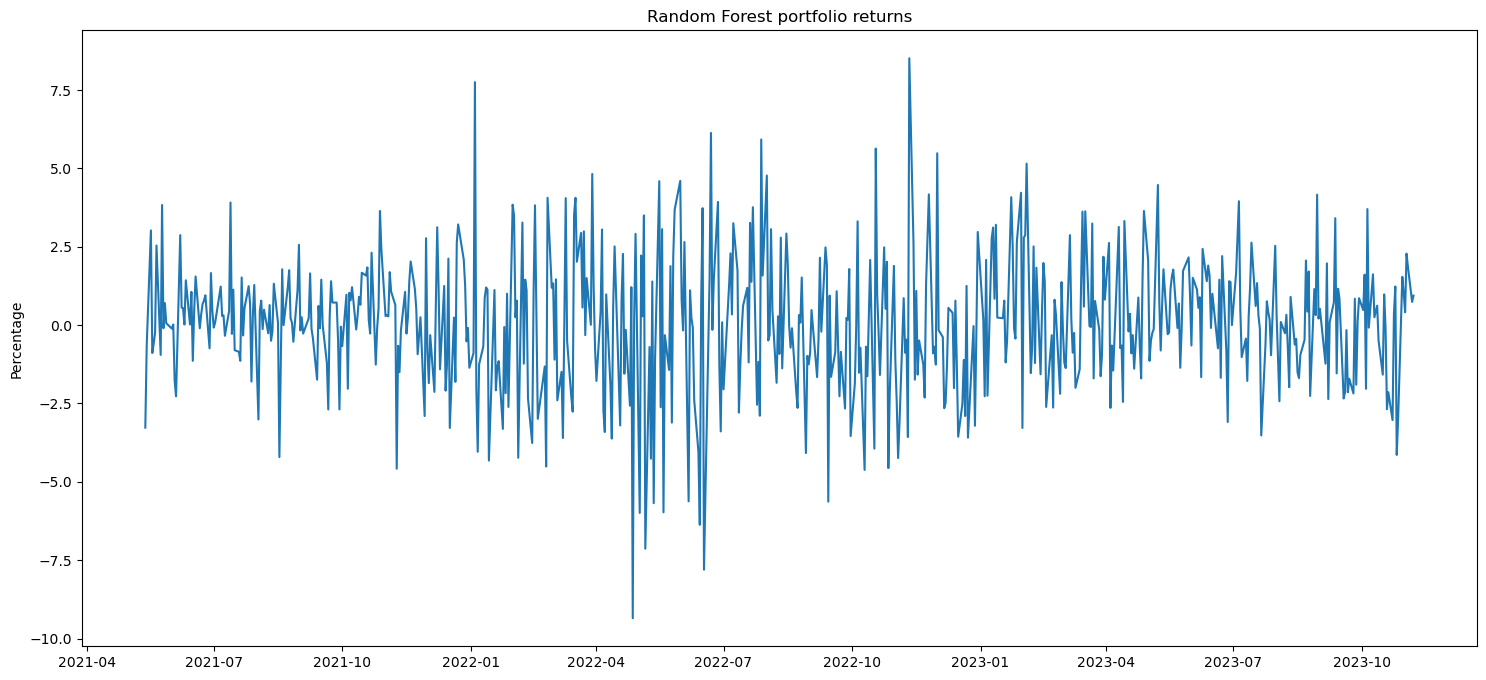

In [8]:
report.plot_portfolio_returns()

### Portfolio value

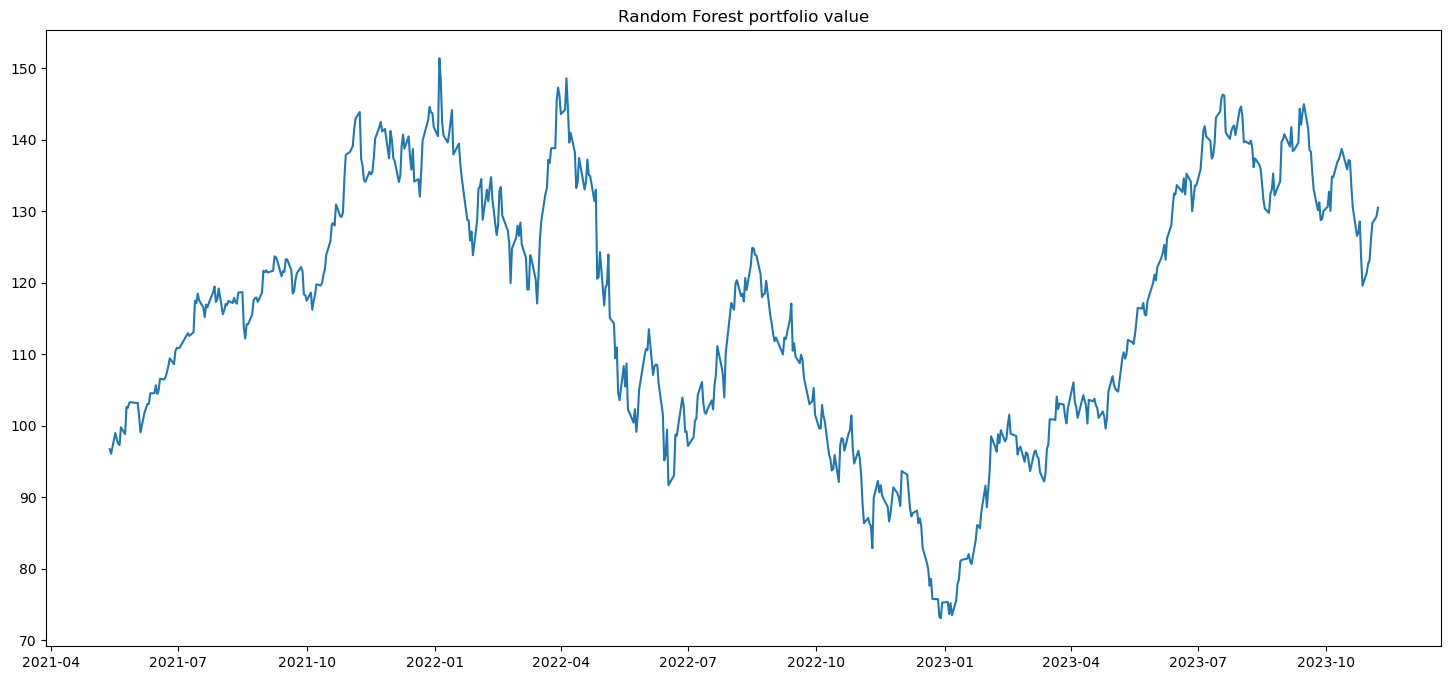

In [9]:
report.plot_portfolio_value()

### Portfolio value breakdown

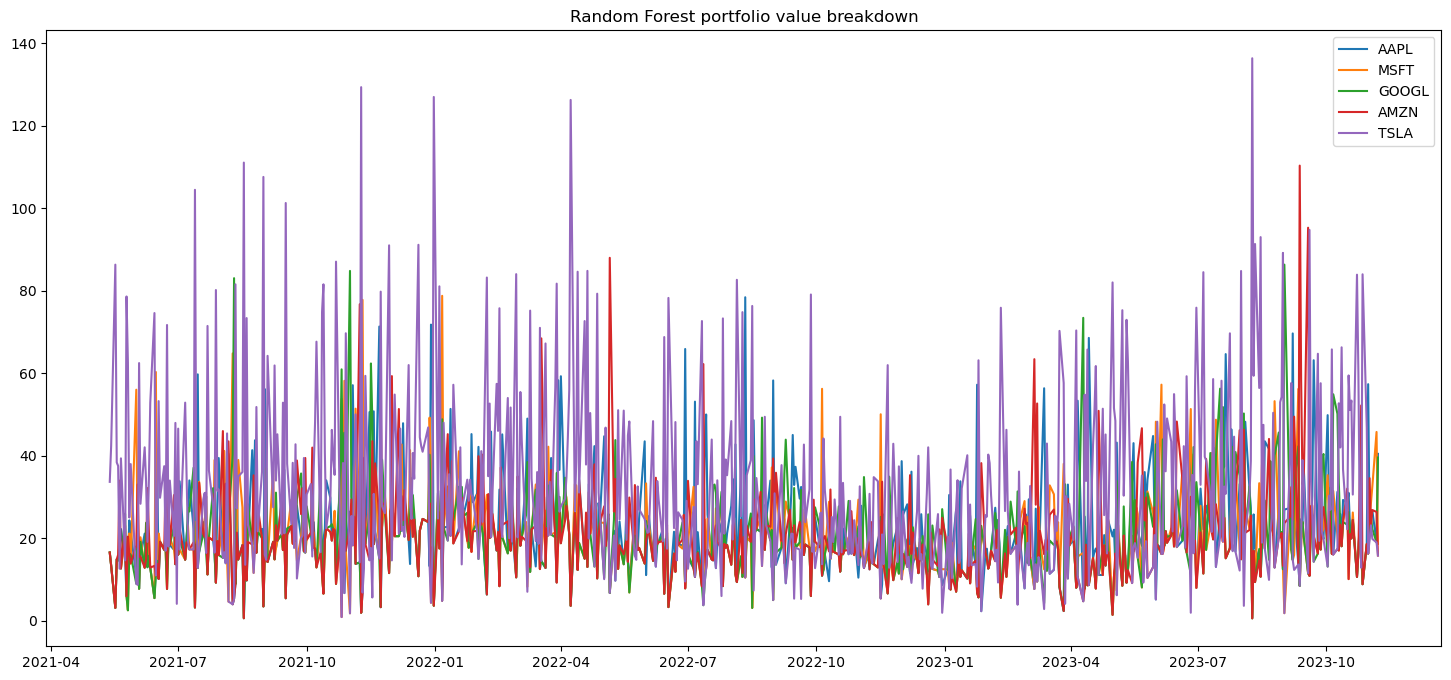

In [10]:
report.plot_portfolio_value_breakdown()